In [860]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from pathlib import Path
from datetime import timedelta
pd.set_option('display.max_columns', None)


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [861]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [862]:
train.isnull().sum().sort_values(ascending=False)/train.shape[0]

uvaerosollayerheight_aerosol_height          0.947095
uvaerosollayerheight_solar_zenith_angle      0.947095
uvaerosollayerheight_solar_azimuth_angle     0.947095
uvaerosollayerheight_sensor_azimuth_angle    0.947095
uvaerosollayerheight_sensor_zenith_angle     0.947095
                                               ...   
country                                      0.000000
city                                         0.000000
site_longitude                               0.000000
site_latitude                                0.000000
pm2_5                                        0.000000
Length: 80, dtype: float64

In [863]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


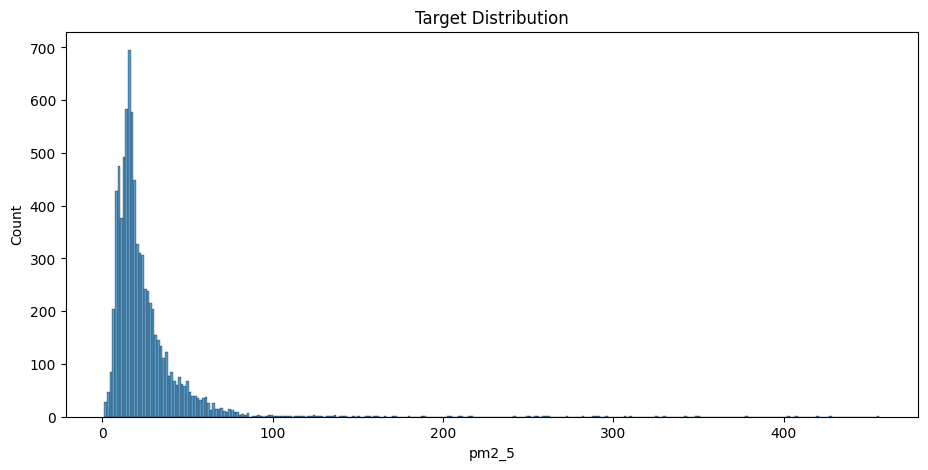

In [864]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

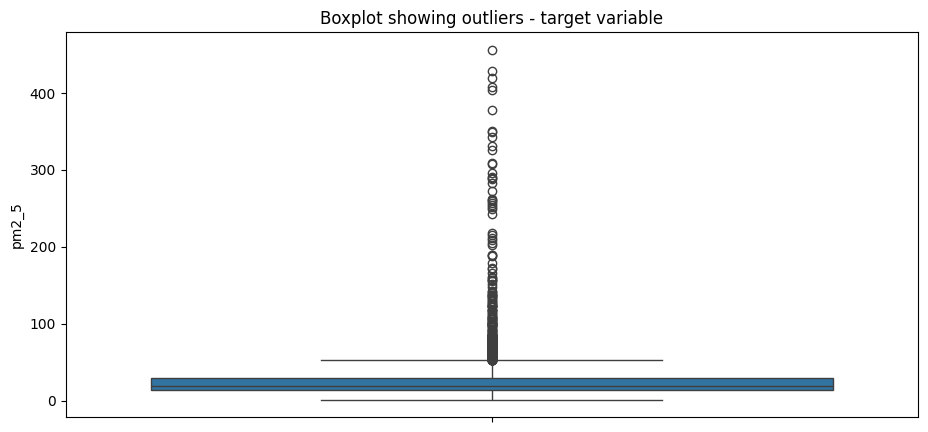

In [865]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

In [866]:
import pandas as pd
from scipy.stats.mstats import winsorize

# Winsorize the PM2.5 column to handle outliers
train['pm2_5'] = winsorize(train['pm2_5'], limits=(0.15,0.07))

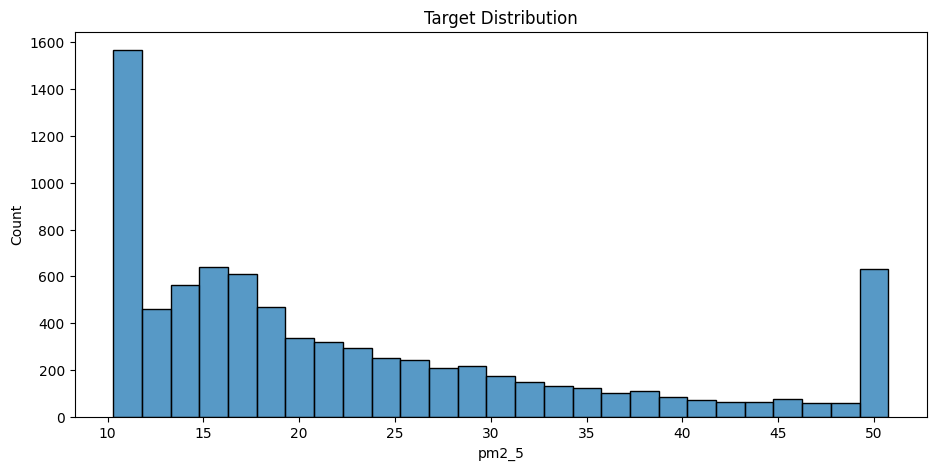

In [867]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

In [868]:
train['pm2_5'] = train['pm2_5']+1.6


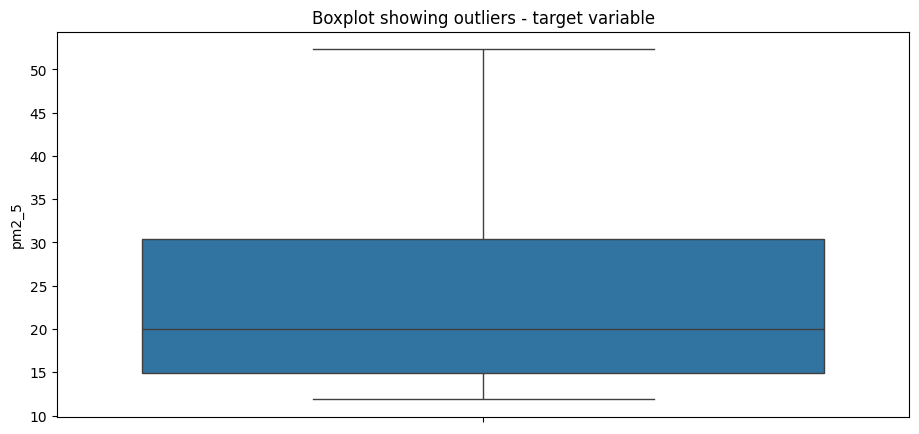

In [869]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()


In [870]:
train = train.sort_values(by=['city','date'])
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
7946,id_kckponblua,64ef31227771f10013f8b066,-3.38065,29.38383,Bujumbura,Burundi,2023-11-04,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685403,830141.437500,-100.412834,32.509525,-113.255730,33.186264,0.116598,2.374336,0.280684,228.055298,0.827587,-100.412834,32.509525,-113.255730,33.186264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827591,54901.082031,5134.122559,62186.304687,4134.122559,7.747695,0.334881,-100.412849,32.509655,-113.255730,33.186287,29.104000
7947,id_gshykfsukc,64ef31227771f10013f8b066,-3.38065,29.38383,Bujumbura,Burundi,2023-11-08,12,0.000053,0.834035,0.000044,0.272225,-98.194786,61.065216,-112.312523,39.292221,0.000085,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.00002,0.000034,0.000134,9580.895123,0.06455,0.067366,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.000047,1.265092,0.000001,0.343269,39.282251,-112.259267,61.065073,-98.203111,0.064541,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.115969,3.233901,0.377243,229.012628,0.348761,-98.203111,61.065073,-112.259267,39.282251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.872750
7948,id_aqxf9kcpqu,64ef31227771f10013f8b066,-3.38065,29.38383,Bujumbura,Burundi,2023-11-09,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.136

In [871]:
# Ensure the date column is in datetime format
train['date'] = pd.to_datetime(train['date'])

# Sort the dataframe by city and date
train = train.sort_values(by=['city', 'date'])

# Function to calculate the rolling mean within a 2-day window
def fill_nan_mean_within_range(df, column_name):
    df.set_index('date', inplace=True)
    df[column_name + '_mean'] = (
        df.groupby('city')[column_name]
        .rolling('4D', min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    df[column_name] = df[column_name].combine_first(df[column_name + '_mean'])
    df.drop(columns=[column_name + '_mean'], inplace=True)
    df.reset_index(inplace=True)
    return df

# Apply the function to each column containing NaN values
for column in train.columns[train.isna().any()]:
    train = fill_nan_mean_within_range(train, column)

In [872]:
column_dtype = train['hour'].dtype
print(f"The data type of the column is: {column_dtype}")


The data type of the column is: int64


In [882]:
sulphurdioxidecolumns_to_sum = [
    'sulphurdioxide_sensor_azimuth_angle',
    'sulphurdioxide_sensor_zenith_angle',
    'sulphurdioxide_solar_azimuth_angle',
    'sulphurdioxide_solar_zenith_angle',
   ]

   # Create a new column with the sum of all specified columns
train['sulphurdioxidesum_of_columns'] = train[sulphurdioxidecolumns_to_sum].sum(axis=1)
test['sulphurdioxidesum_of_columns'] = test[sulphurdioxidecolumns_to_sum].sum(axis=1)




carbonmonoxidecolumns_to_sum = [
    'carbonmonoxide_sensor_azimuth_angle',
    'carbonmonoxide_sensor_zenith_angle',
    'carbonmonoxide_solar_azimuth_angle',
    'carbonmonoxide_solar_zenith_angle',
   ]

   # Create a new column with the sum of all specified columns
train['carbonmonoxidesum_of_columns'] = train[carbonmonoxidecolumns_to_sum].sum(axis=1)
test['carbonmonoxidesum_of_columns'] = test[carbonmonoxidecolumns_to_sum].sum(axis=1)

nitrogendioxidecolumns_to_sum = [
    'nitrogendioxide_sensor_azimuth_angle',
    'nitrogendioxide_sensor_zenith_angle',
    'nitrogendioxide_solar_azimuth_angle',
    'nitrogendioxide_solar_zenith_angle',
   ]

   # Create a new column with the sum of all specified columns
train['nitrogendioxidesum_of_columns'] = train[nitrogendioxidecolumns_to_sum].sum(axis=1)
test['nitrogendioxidesum_of_columns'] = test[nitrogendioxidecolumns_to_sum].sum(axis=1)
columns_to_sum = [
    'formaldehyde_solar_zenith_angle',
    'formaldehyde_solar_azimuth_angle',
    'formaldehyde_sensor_zenith_angle',
    'formaldehyde_sensor_azimuth_angle',
       'uvaerosolindex_sensor_azimuth_angle',
       'uvaerosolindex_sensor_zenith_angle',
       'uvaerosolindex_solar_azimuth_angle',
       'uvaerosolindex_solar_zenith_angle',
       'ozone_sensor_azimuth_angle',
       'ozone_sensor_zenith_angle',
       'ozone_solar_azimuth_angle',
       'ozone_solar_zenith_angle',
       'uvaerosollayerheight_sensor_zenith_angle',
       'uvaerosollayerheight_sensor_azimuth_angle',
       'uvaerosollayerheight_solar_azimuth_angle',
       'uvaerosollayerheight_solar_zenith_angle',
       'cloud_sensor_azimuth_angle',
       'cloud_sensor_zenith_angle',
       'cloud_solar_azimuth_angle',
       'cloud_solar_zenith_angle'
   ]

   # Create a new column with the sum of all specified columns
train['sum_of_columns'] = train[columns_to_sum].sum(axis=1)
test['sum_of_columns'] = test[columns_to_sum].sum(axis=1)





In [874]:
train.tail()

,date,id,site_id,site_latitude,site_longitude,city,country,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
8066,2024-01-27,id_tn51gcoz4a,644841fe1319140029aced6e,-1.283724,36.810364,Nairobi,Kenya,10,0.000199,0.764215,0.000152,0.054388,73.323982,48.218433,-144.969070,21.264837,0.000064,1.0,0.029279,1155.861694,1.0,829591.1875,71.580040,48.108143,-144.857513,21.299816,0.000069,0.000038,0.000031,0.000136,7311.869141,-0.970848,0.042289,829618.8750,73.323982,48.218433,-144.969070,21.264837,0.000270,1.054109,0.000211,0.054388,21.264837,-144.969070,48.218433,73.323982,-0.970830,829618.8750,73.323982,48.218433,-144.969070,21.264837,0.110373,2.563554,0.288218,237.581467,0.045100,73.323982,48.218433,-144.969070,21.264837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047826,67883.929688,3458.536865,76573.898438,2458.536865,4.868147,0.187310,73.323975,48.218334,-144.969040,21.264854,14.934286
8067,2024-01-27,id_msdjbr87s4,644fa58ae5001000290df1e2,-1.286301,36.830761,Nairobi,Kenya,10,-0.000128,0.729167,-0.000091,0.127196,73.348643,47.945916,-144.883971,21.312743,-0.000039,1.0,0.029279,1155.861694,1.0,829591.1875,71.580040,48.108143,-144.857513,21.299816,0.000053,0.000022,0.000031,0.000111,7311.869141,-0.842241,0.081941,829618.8750,73.348643,47.945916,-144.883971,21.312743,0.000158,1.058020,0.000094,0.127196,21.312743,-144.883971,47.945916,73.348643,-0.842223,829618.8750,73.348643,47.945916,-144.883971,21.312743,0.109551,2.554837,0.284269,230.836210,0.122187,73.348643,47.945916,-144.883971,21.312743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154551,53045.722656,5453.724121,60248.230469,4453.724121,

In [875]:

# Select X and y features for modelling
train_num_df = train.select_dtypes(include=['number'])


In [876]:

test_num_df =test.select_dtypes(include=['number'])
test_num_df.columns



Index(['site_latitude', 'site_longitude', 'hour',
       'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_n

In [877]:
X = train_num_df.drop('pm2_5', axis = 1)
y = train.pm2_5

test_df = test_num_df[X.columns]
X.columns


Index(['site_latitude', 'site_longitude', 'hour',
       'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_n

In [878]:
X.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,-3.38065,29.38383,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685403,830141.437500,-100.412834,32.509525,-113.255730,33.186264,0.116598,2.374336,0.280684,228.055298,0.827587,-100.412834,32.509525,-113.255730,33.186264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827591,54901.082031,5134.122559,62186.304687,4134.122559,7.747695,0.334881,-100.412849,32.509655,-113.255730,33.186287
1,-3.38065,29.38383,12,0.000053,0.834035,0.000044,0.272225,-98.194786,61.065216,-112.312523,39.292221,0.000085,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.00002,0.000034,0.000134,9580.895123,0.06455,0.067366,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.000047,1.265092,0.000001,0.343269,39.282251,-112.259267,61.065073,-98.203111,0.064541,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.115969,3.233901,0.377243,229.012628,0.348761,-98.203111,61.065073,-112.259267,39.282251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-3.38065,29.38383,11,0.000053,0.834035,0.000044,0.272225,-98.194786,61.065216,-112.312523,39.292221,0.000085,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,0.00002,0.000034,0.000134,9580.895123,0.06455,0.067366,830285.155442,-98.203111,61.065073,-112.259267,39.282251,0.000047,1.265092,0.000001,0.343269,39.282251,-112.259267,61.065073,-98.203111,-0.136088,830206.375000,-99.661987,41.889915,-114.965324,35.046345,0.115215,2.509487,0.293480,228.1577

In [879]:
test.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,id_ihxgrbq8bw,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-06,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
1,id_dg6s4fhiwe,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-07,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id_f7hwwtmuzp,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-08,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9.0,0.037453,3046.3140

In [880]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = LGBMRegressor()
model.fit(X_train, y_train)

# Predictions on the test set
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE for train and test sets
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE for Train Set:", rmse_train)
print("RMSE for Test Set:", rmse_test)

# Make predictions on the test set for submission
preds = model.predict(test_df)

# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})

# Preview sub file
sub.head()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17889
[LightGBM] [Info] Number of data points in the train set: 5649, number of used features: 74
[LightGBM] [Info] Start training from score 24.421570
RMSE for Train Set: 4.252112264918147
RMSE for Test Set: 5.83781942202097


,id,pm2_5
0,id_ihxgrbq8bw,16.057681
1,id_dg6s4fhiwe,18.074432
2,id_f7hwwtmuzp,12.891096
3,id_ioese5awdg,24.331259
4,id_hdw320zpls,16.382721


In [881]:

sub.to_csv('submission.csv', index = False)